In [ ]:
pip install unidecode sastrawi python-Levenshtein git+https://github.com/ariaghora/mpstemmer.git;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ariaghora/mpstemmer.git to /tmp/pip-req-build-1v5lg_y8
  Running command git clone -q https://github.com/ariaghora/mpstemmer.git /tmp/pip-req-build-1v5lg_y8
     |████████████████████████████████| 235 kB 33.7 MB/s 
     |████████████████████████████████| 209 kB 56.4 MB/s 
     |████████████████████████████████| 174 kB 79.3 MB/s 
     |████████████████████████████████| 2.2 MB 77.1 MB/s 
  Created wheel for mpstemmer: filename=mpstemmer-0.1.0-py3-none-any.whl size=99820 sha256=b75ed9d93f763fb8e03da0275d2026b22ecd83560a0ac7a0e646d202bd434297
  Stored in directory: /tmp/pip-ephem-wheel-cache-v4apeiq_/wheels/5c/f4/b7/9a03c2b80553c1ef45ee7971522137e4cd51db0ac5752f8d8a
Successfully built mpstemmer


In [ ]:
#DATA PROCESSING
import re
from unidecode import unidecode
import string
import pandas as pd
from google.colab import files
import itertools

#toknize
import nltk
from nltk.tokenize import word_tokenize,MWETokenizer
from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')



#stopword 
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords

#stemmer
from mpstemmer import MPStemmer



#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Visualisasi
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<H1> LOAD DATA </H1>

In [ ]:
uploaded = files.upload()

Saving train_preprocess.tsv to train_preprocess.tsv


In [ ]:
df = pd.read_csv(r'/content/train_preprocess.tsv', sep='\t',names = ['data','label'],encoding='latin-1')
df

,data,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [ ]:
jumlah_data_per_label = df['label'].value_counts()
print(jumlah_data_per_label)

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64


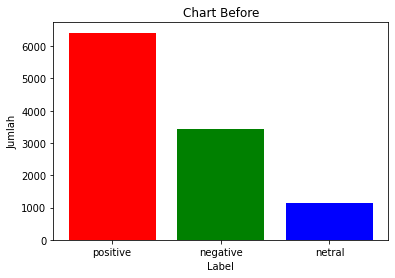

In [ ]:
#COUNT LABEL 
import matplotlib 

jumlah_data_per_label = df['label'].value_counts()
label_positive = jumlah_data_per_label[0]
label_negative =  jumlah_data_per_label[1]
lebel_netral =  jumlah_data_per_label[2]

label = ['positive', 'negative', 'netral']
jumlah = [label_positive,label_negative, lebel_netral]

plt.bar(label, jumlah, color = ['red','green','blue'])
plt.title('Chart Before')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.savefig('plot_before.png')
plt.show()

<H1> DATA PROCESSING <H1>

In [ ]:
#case fold 
def case_fold(text):
    #membuat semua komentar menjadi huruf kecil 
    text = text.lower()
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    #replace - with space
    text = text.replace('-',' ')
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove consecutive word
    text = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text)
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    text.replace("http://", " ").replace("https://", " ")
    #remove punctuation
    text = text.translate(str.maketrans("","",string.punctuation))
    #remove whitestrip
    text = text.strip()
    #remove multiple whitespace into single whitespace
    text = re.sub('\s+',' ',text)
    #remove single char
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    #remove url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)

    return text
df['case_fold'] = df['data'].apply(case_fold)
df

,data,label,case_fold
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mbri hujjah partai ...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...
...,...,...,...
10995,tidak kecewa,positive,tidak kecewa
10996,enak rasa masakan nya apalagi kepiting yang me...,positive,enak rasa masakan nya apalagi kepiting yang me...
10997,hormati partai-partai yang telah berkoalisi,neutral,hormati partai yang telah berkoalisi
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative,pagi di tol pasteur sudah macet parah bikin je...


In [ ]:
#TOKENIZE
def multiword_tokenize(text):
  mwe = open("/content/mwe.txt", "r",).read().split("\n")
  protected_tuples = [word_tokenize(word) for word in mwe]
  protected_tuples_underscore = ['_'.join(word) for word in protected_tuples]
  tokenizer = MWETokenizer(protected_tuples)
  # Tokenize the text.
  tokenized_text = tokenizer.tokenize(word_tokenize(text))
  # Replace the underscored protected words with the original MWE
  for i, token in enumerate(tokenized_text):
    if token in protected_tuples_underscore:
      tokenized_text[i] = mwe[protected_tuples_underscore.index(token)]
    return tokenized_text

df['tokenize'] = df['case_fold'].apply(multiword_tokenize)
df = df [['data','case_fold','tokenize','label']]
df

,data,case_fold,tokenize,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,"[warung, ini, dimiliki, oleh, pengusaha, pabri...",positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k212 mbri hujjah partai ...,"[mohon, ulama, lurus, dan, k212, mbri, hujjah,...",neutral
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatera bandung tem...,"[lokasi, strategis, di, jalan, sumatera, bandu...",positive
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unboxing pake...,"[betapa, bahagia, nya, diri, ini, saat, unboxi...",positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,duh jadi mahasiswa jangan sombong dong kasih k...,"[duh, jadi, mahasiswa, jangan, sombong, dong, ...",negative
...,...,...,...,...
10995,tidak kecewa,tidak kecewa,[tidak kecewa],positive
10996,enak rasa masakan nya apalagi kepiting yang me...,enak rasa masakan nya apalagi kepiting yang me...,"[enak, rasa, masakan, nya, apalagi, kepiting, ...",positive
10997,hormati partai-partai yang telah berkoalisi,hormati partai yang telah berkoalisi,"[hormati, partai, yang, telah, berkoalisi]",neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",pagi di tol pasteur sudah macet parah bikin je...,"[pagi, di, tol, pasteur, sudah, macet, parah, ...",negative


In [ ]:
#normalisasi
normalized_word = pd.read_excel("/content/normalisasi.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(text):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in text]

    
df['normalisasi'] = df['tokenize'].apply(normalized_term)
df

<ipython-input-10-44f9eac43c6f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['normalisasi'] = df['tokenize'].apply(normalized_term)


,data,case_fold,tokenize,label,normalisasi
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,"[warung, ini, dimiliki, oleh, pengusaha, pabri...",positive,"[warung, ini, dimiliki, oleh, pengusaha, pabri..."
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k212 mbri hujjah partai ...,"[mohon, ulama, lurus, dan, k212, mbri, hujjah,...",neutral,"[mohon, ulama, lurus, dan, k212, mbri, hujjah,..."
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatera bandung tem...,"[lokasi, strategis, di, jalan, sumatera, bandu...",positive,"[lokasi, strategis, di, jalan, sumatra, bandun..."
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unboxing pake...,"[betapa, bahagia, nya, diri, ini, saat, unboxi...",positive,"[betapa, bahagia, nya, diri, ini, saat, unboxi..."
4,duh . jadi mahasiswa jangan sombong dong . kas...,duh jadi mahasiswa jangan sombong dong kasih k...,"[duh, jadi, mahasiswa, jangan, sombong, dong, ...",negative,"[aduh, jadi, mahasiswa, jangan, sombong, dong,..."
...,...,...,...,...,...
10995,tidak kecewa,tidak kecewa,[tidak kecewa],positive,[tidak kecewa]
10996,enak rasa masakan nya apalagi kepiting yang me...,enak rasa masakan nya apalagi kepiting yang me...,"[enak, rasa, masakan, nya, apalagi, kepiting, ...",positive,"[enak, rasa, masakan, nya, apalagi, kepiting, ..."
10997,hormati partai-partai yang telah berkoalisi,hormati partai yang telah berkoalisi,"[hormati, partai, yang, telah, berkoalisi]",neutral,"[hormati, partai, yang, telah, berkoalisi]"
10998,"pagi pagi di tol pasteur sudah macet parah , b...",pagi di tol pasteur sudah macet parah bikin je...,"[pagi, di, tol, pasteur, sudah, macet, parah, ...",negative,"[pagi, di, tol, pasteur, sudah, macet, parah, ..."


In [ ]:
#STOPWORDS
dump_stopwords = stopwords.words('indonesian')
extend_stopword = open("/content/extend_stopword.txt", "r",).read().split("\n")
for element_es in extend_stopword:
  dump_stopwords.append(element_es)
delete_from_stopword = open("/content/delete_from_stopword.txt", "r",).read().split("\n")
for element in delete_from_stopword:
  if element in dump_stopwords:
    dump_stopwords.remove(element)
list_stopwords = set(dump_stopwords)
def stopwords_removal(text):
  return [word for word in text if word not in list_stopwords]

df['stopwords'] = df['normalisasi'].apply(stopwords_removal)


df

<ipython-input-11-88d217d93ef5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords'] = df['normalisasi'].apply(stopwords_removal)


,data,case_fold,tokenize,label,normalisasi,stopwords
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,"[warung, ini, dimiliki, oleh, pengusaha, pabri...",positive,"[warung, ini, dimiliki, oleh, pengusaha, pabri...","[warung, dimiliki, pengusaha, pabrik, puluhan,..."
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k212 mbri hujjah partai ...,"[mohon, ulama, lurus, dan, k212, mbri, hujjah,...",neutral,"[mohon, ulama, lurus, dan, k212, mbri, hujjah,...","[mohon, ulama, lurus, k212, mbri, hujjah, part..."
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatera bandung tem...,"[lokasi, strategis, di, jalan, sumatera, bandu...",positive,"[lokasi, strategis, di, jalan, sumatra, bandun...","[lokasi, strategis, jalan, sumatra, bandung, n..."
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unboxing pake...,"[betapa, bahagia, nya, diri, ini, saat, unboxi...",positive,"[betapa, bahagia, nya, diri, ini, saat, unboxi...","[betapa, bahagia, unboxing, paket, barang, bag..."
4,duh . jadi mahasiswa jangan sombong dong . kas...,duh jadi mahasiswa jangan sombong dong kasih k...,"[duh, jadi, mahasiswa, jangan, sombong, dong, ...",negative,"[aduh, jadi, mahasiswa, jangan, sombong, dong,...","[aduh, mahasiswa, jangan, sombong, kasih, kart..."
...,...,...,...,...,...,...
10995,tidak kecewa,tidak kecewa,[tidak kecewa],positive,[tidak kecewa],[tidak kecewa]
10996,enak rasa masakan nya apalagi kepiting yang me...,enak rasa masakan nya apalagi kepiting yang me...,"[enak, rasa, masakan, nya, apalagi, kepiting, ...",positive,"[enak, rasa, masakan, nya, apalagi, kepiting, ...","[enak, masakan, kepiting, menyenangkan, memili..."
10997,hormati partai-partai yang telah berkoalisi,hormati partai yang telah berkoalisi,"[hormati, partai, yang, telah, berkoalisi]",neutral,"[hormati, partai, yang, telah, berkoalisi]","[hormati, partai, berkoalisi]"
10998,"pagi pagi di tol pasteur sudah macet parah , b...",pagi di tol pasteur sudah macet parah bikin je...,"[pagi, di, tol, pasteur, sudah, macet, parah, ...",negative,"[pagi, di, tol, pasteur, sudah, macet, parah, ...","[pagi, tol, pasteur, macet, parah, jengkel]"


In [ ]:
#STEMMER
stemmer = MPStemmer()
def stemmed_wrapper(term):
  return stemmer.stem(term)
term_dict = {}
for document in df["stopwords"]:
  for term in document:
    if term not in term_dict:
      term_dict[term] = " "
for term in term_dict:
  term_dict[term] = stemmed_wrapper(term) 
# apply stemmed term to dataframe
def get_stemmed_term(text):
  return [term_dict[term] for term in text]

df["stemmer"] = df["stopwords"].apply(get_stemmed_term).apply(normalized_term).apply(stopwords_removal)
df  

<ipython-input-12-62e78b5c78f9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stemmer"] = df["stopwords"].apply(get_stemmed_term).apply(normalized_term).apply(stopwords_removal)


,data,case_fold,tokenize,label,normalisasi,stopwords,stemmer
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,"[warung, ini, dimiliki, oleh, pengusaha, pabri...",positive,"[warung, ini, dimiliki, oleh, pengusaha, pabri...","[warung, dimiliki, pengusaha, pabrik, puluhan,...","[warung, milik, usaha, pabrik, puluh, kenal, p..."
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k212 mbri hujjah partai ...,"[mohon, ulama, lurus, dan, k212, mbri, hujjah,...",neutral,"[mohon, ulama, lurus, dan, k212, mbri, hujjah,...","[mohon, ulama, lurus, k212, mbri, hujjah, part...","[mohon, ulama, lurus, k212, mbri, hujjah, part..."
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatera bandung tem...,"[lokasi, strategis, di, jalan, sumatera, bandu...",positive,"[lokasi, strategis, di, jalan, sumatra, bandun...","[lokasi, strategis, jalan, sumatra, bandung, n...","[lokasi, strategis, jalan, sumatra, bandung, n..."
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unboxing pake...,"[betapa, bahagia, nya, diri, ini, saat, unboxi...",positive,"[betapa, bahagia, nya, diri, ini, saat, unboxi...","[betapa, bahagia, unboxing, paket, barang, bag...","[betapa, bahagia, unboxing, paket, barang, bag..."
4,duh . jadi mahasiswa jangan sombong dong . kas...,duh jadi mahasiswa jangan sombong dong kasih k...,"[duh, jadi, mahasiswa, jangan, sombong, dong, ...",negative,"[aduh, jadi, mahasiswa, jangan, sombong, dong,...","[aduh, mahasiswa, jangan, sombong, kasih, kart...","[aduh, mahasiswa, jangan, sombong, kasih, kart..."
...,...,...,...,...,...,...,...
10995,tidak kecewa,tidak kecewa,[tidak kecewa],positive,[tidak kecewa],[tidak kecewa],[tidak kecewa]
10996,enak rasa masakan nya apalagi kepiting yang me...,enak rasa masakan nya apalagi kepiting yang me...,"[enak, rasa, masakan, nya, apalagi, kepiting, ...",positive,"[enak, rasa, masakan, nya, apalagi, kepiting, ...","[enak, masakan, kepiting, menyenangkan, memili...","[enak, kepiting, senang, pilih, kepiting, sega..."
10997,hormati partai-partai yang telah berkoalisi,hormati partai yang telah berkoalisi,"[hormati, partai, yang, telah, berkoalisi]",neutral,"[hormati, partai, yang, telah, berkoalisi]","[hormati, partai, berkoalisi]","[hormat, partai, koalisi]"
10998,"pagi pagi di tol pasteur sudah macet parah , b...",pagi di tol pasteur sudah macet parah bikin je...,"[pagi, di, tol, pasteur, sudah, macet, parah, ...",negative,"[pagi, di, tol, pasteur, sudah, macet, parah, ...","[pagi, tol, pasteur, macet, parah, jengkel]","[pagi, tol, pasteur, macet, parah, jengkel]"


In [ ]:
#clean
def clean_text(text):
    komentar = " "
    return (komentar.join(text))
df['clean'] = df['stemmer'].apply(clean_text)
df = df [['data','case_fold','tokenize','normalisasi','stopwords','stemmer','clean','label']]

<ipython-input-13-b4e4585da740>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean'] = df['stemmer'].apply(clean_text)


In [ ]:
df.to_excel('test.xlsx')

In [ ]:
pip install textdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_post = df.loc[df['label'] == 'positive']

import textdistance

df_post["match"] = df_post["clean"].map(
    lambda x: [
        i
        for i, text in enumerate(df_post["clean"])
        if textdistance.jaro_winkler(x, text) >= 0.5
    ]
)

# Iterate to remove similar rows (keeping only the first one)
indices = []
for i, row in df_post.iterrows():
    indices.append(i)
    df_post = df_post.drop(
        index=[item for item in row["match"] if item not in indices], errors="ignore"
    )

# Clean up
df_post = df_post.drop(columns="match")

df_post 

<ipython-input-18-8cf00e37ced3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_post["match"] = df_post["clean"].map(


,data,case_fold,tokenize,normalisasi,stopwords,stemmer,clean,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,"[warung, ini, dimiliki, oleh, pengusaha, pabri...","[warung, ini, dimiliki, oleh, pengusaha, pabri...","[warung, dimiliki, pengusaha, pabrik, puluhan,...","[warung, milik, usaha, pabrik, puluh, kenal, p...",warung milik usaha pabrik puluh kenal putih ba...,positive
6416,"tempat yang asri sekali , makanan nya enak unt...",tempat yang asri sekali makanan nya enak untuk...,"[tempat, yang, asri, sekali, makanan, nya, ena...","[tempat, yang, asri, sekali, makanan, nya, ena...","[asri, makanan, enak, suasana, dingin, makanan...","[asri, makan, enak, suasana, dingin, makan, tr...",asri makan enak suasana dingin makan tradision...,positive
6417,restoran ini terletak di sekitar karang setra ...,restoran ini terletak di sekitar karang setra ...,"[restoran, ini, terletak, di, sekitar, karang,...","[restoran, ini, terletak, di, sekitar, karang,...","[restoran, terletak, karang, setra, restoran, ...","[restoran, letak, karang, setra, restoran, hid...",restoran letak karang setra restoran hidang me...,positive
6418,tempat ini merupakan gabungan antara galery da...,tempat ini merupakan gabungan antara galery da...,"[tempat, ini, merupakan, gabungan, antara, gal...","[tempat, ini, merupakan, gabungan, antara, gal...","[gabungan, galery, kafe, panorama, lokasi, cuk...","[gabung, galery, kafe, panorama, lokasi, cukup...",gabung galery kafe panorama lokasi cukup menaw...,positive
6419,"pertama kali makan di sini , suasana nya sepi ...",pertama kali makan di sini suasana nya sepi mu...,"[pertama, kali, makan, di, sini, suasana, nya,...","[pertama, kali, makan, di, sini, suasana, nya,...","[kali, makan, suasana, sepi, sedikit, kalah, s...","[kali, makan, suasana, sepi, sedikit, kalah, s...",kali makan suasana sepi sedikit kalah saing re...,positive
...,...,...,...,...,...,...,...,...
10992,kalau memang jala nya sudah begitu terima saja...,kalau memang jala nya sudah begitu terima saja...,"[kalau, memang, jala, nya, sudah, begitu, teri...","[kalau, memang, jala, nya, sudah, begitu, teri...","[jala, terima, ikhlas]","[jala, terima, ikhlas]",jala terima ikhlas,positive
10994,tidak bosan,tidak bosan,"[tidak, bosan]","[tidak, bosan]","[tidak, bosan]","[tidak, bosan]",tidak bosan,positive
10995,tidak kecewa,tidak kecewa,[tidak kecewa],[tidak kecewa],[tidak kecewa],[tidak kecewa],tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,enak rasa masakan nya apalagi kepiting yang me...,"[enak, rasa, masakan, nya, apalagi, kepiting, ...","[enak, rasa, masakan, nya, apalagi, kepiting, ...","[enak, masakan, kepiting, menyenangkan, memili...","[enak, kepiting, senang, pilih, kepiting, sega...",enak kepiting senang pilih kepiting segar sela...,positive


In [ ]:
df_neg = df.loc[df['label'] == 'negative']



df_neg["match"] = df_neg["clean"].map(
    lambda x: [
        i
        for i, text in enumerate(df_neg["clean"])
        if textdistance.jaro_winkler(x, text) >= 0.5
    ]
)

# Iterate to remove similar rows (keeping only the first one)
indices = []
for i, row in df_neg.iterrows():
    indices.append(i)
    df_neg = df_neg.drop(
        index=[item for item in row["match"] if item not in indices], errors="ignore"
    )

# Clean up
df_neg = df_neg.drop(columns="match")

df_neg 

<ipython-input-19-97ba25643243>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg["match"] = df_neg["clean"].map(


,data,case_fold,tokenize,normalisasi,stopwords,stemmer,clean,label
4,duh . jadi mahasiswa jangan sombong dong . kas...,duh jadi mahasiswa jangan sombong dong kasih k...,"[duh, jadi, mahasiswa, jangan, sombong, dong, ...","[aduh, jadi, mahasiswa, jangan, sombong, dong,...","[aduh, mahasiswa, jangan, sombong, kasih, kart...","[aduh, mahasiswa, jangan, sombong, kasih, kart...",aduh mahasiswa jangan sombong kasih kartu kuni...,negative
674,banyak orang yang kurang suka untuk berobat ke...,banyak orang yang kurang suka untuk berobat ke...,"[banyak, orang, yang, kurang, suka, untuk, ber...","[banyak, orang, yang, kurang, suka, untuk, ber...","[banyak, kurang, suka, berobat, dokter, biaya,...","[banyak, kurang, suka, obat, dokter, biaya, re...",banyak kurang suka obat dokter biaya relatif c...,negative
3439,tidak puas,tidak puas,"[tidak, puas]","[tidak, puas]","[tidak, puas]","[tidak, puas]",tidak puas,negative
3446,ini orang goblok banget ya . yang belum beres ...,ini orang goblok banget ya yang belum beres ma...,"[ini, orang, goblok, banget, ya, yang, belum, ...","[ini, orang, bodoh, sangat, iya, yang, belum, ...","[bodoh, iya, belum, selesai, banyak, bongkar, ...","[bodoh, iya, belum, selesai, banyak, bongkar, ...",bodoh iya belum selesai banyak bongkar dasar b...,negative
3447,hari senin ku cukup melelahkan,hari senin ku cukup melelahkan,"[hari, senin, ku, cukup, melelahkan]","[hari, senin, ku, cukup, melelahkan]","[senin, ku, cukup, melelahkan]","[senin, ku, cukup, lelah]",senin ku cukup lelah,negative
...,...,...,...,...,...,...,...,...
10982,tolong dibaca pesan saya ! di dalam kotak hand...,tolong dibaca pesan saya di dalam kotak handph...,"[tolong, dibaca, pesan, saya, di, dalam, kotak...","[tolong, dibaca, pesan, saya, di, dalam, kotak...","[tolong, dibaca, pesan, kotak, handphone, tida...","[tolong, baca, pesan, kotak, handphone, tidak_...",tolong baca pesan kotak handphone tidak_ada ka...,negative
10985,"sumpah gue kecewa banget dengan sms , cuma tea...",sumpah gue kecewa banget dengan sms cuma tease...,"[sumpah, gue, kecewa, banget, dengan, sms, cum...","[sumpah, saya, kecewa, sangat, dengan, sms, cu...","[sumpah, kecewa, sms, teaser, isi, got7, eh, g...","[sumpah, kecewa, sms, teaser, isi, got7, eh, g...",sumpah kecewa sms teaser isi got7 eh got7 sedikit,negative
10989,tadinya pengin mengantar teman dari kalau ke r...,tadinya pengin mengantar teman dari kalau ke r...,"[tadinya, pengin, mengantar, teman, dari, kala...","[tadinya, ingin, mengantar, teman, dari, kalau...","[ingin, mengantar, teman, resto, terpopuler, b...","[ingin, teman, resto, populer, bandung, rekome...",ingin teman resto populer bandung rekomendasi ...,negative
10991,dapat rom awal abad,dapat rom awal abad,"[dapat, rom, awal, abad]","[dapat, rom, awal, abad]","[dapat, rom, abad]","[dapat, rom, abad]",dapat rom abad,negative


In [ ]:
#create df_netral
df_netral = df.loc[df['label'] == 'neutral']



In [ ]:

#generete random with max number sama with neutral
nMax = 1148

df_post_copy = df_post.sample(n=nMax)
df_neg_copy = df_neg.sample(n=nMax)



frames = [df_post_copy[['clean','label']], df_neg_copy[['clean','label']], df_netral[['clean','label']]]

final_df = pd.concat(frames)
final_df_copy = final_df.copy()

# Applying the condition
label = {'neutral': 0, 'positive': 1, 'negative': -1}
final_df['label'] = final_df['label'].replace(label)

results = set()
final_df['clean'].str.lower().str.split().apply(results.update)
print(len(results))

7123


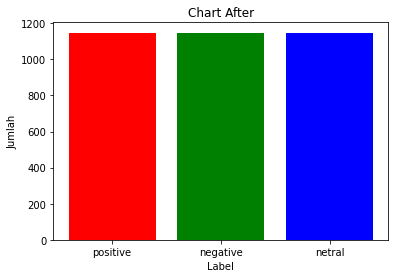

In [ ]:
after_jumlah_data_per_label = final_df['label'].value_counts()
after_label_positive = after_jumlah_data_per_label[0]
after_label_negative =  after_jumlah_data_per_label[1]
after_lebel_netral =  after_jumlah_data_per_label[-1]

label = ['positive', 'negative', 'netral']
jumlah = [after_label_positive,after_label_negative, after_lebel_netral]

plt.bar(label, jumlah, color = ['red','green','blue'])
plt.title('Chart After')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.savefig('plot_after.png')
plt.show()


In [ ]:
# final_df_copy = final_df.copy()
# nMax = 1148 #change to 2500
# #1148 diambil dari max yang ppaling sedikit yaitu netral
# final_df = final_df.groupby('label').apply(lambda x: x.sample(n=min(nMax, len(x))))

# print(final_df['label'].value_counts())
# # Name: label, dtype: int64

In [ ]:
final_df.to_excel('test.xlsx')

In [ ]:
results = set()
final_df['clean'].str.lower().str.split().apply(results.update)
print(len(results))

7189


In [ ]:
final_df = final_df.reset_index()
final_df

,index,clean,label
0,9167,lebih baik tap peluang baru fintect ar vr tech...,1
1,10910,restoran mewah nuansa elegant pandang indah ke...,1
2,8601,malam cuaca dingiikan ambil masuk angin menu b...,1
3,8459,tinggal bandung keluarga senang wisata kuliner...,1
4,8350,tidak jus stroberi enak bandung 12 lebih setia...,1
...,...,...,...
3439,10925,partai kebangkitan bangsa benar charly setia b...,0
3440,10967,pernah percaya body lotion citra bulu tambah b...,0
3441,10969,bu susi marah menteri luhut boleh kapal asing ...,0
3442,10993,demokrat dorong upaya mandiri energi nasional,0


<H1> BOW dan TF-IDF </H1>

In [ ]:
#BOW
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X_train_counts = cv.fit_transform(final_df['clean'])
X_train_counts.shape

(3444, 7152)

In [ ]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tfidf.transform(X_train_counts)
X_train_tf.shape

(3444, 7134)

<h1> VECTORIZER LAIN </H1>

In [ ]:
vectorizer = TfidfVectorizer (max_features=7300)
v_data = vectorizer.fit_transform(final_df['clean']).toarray()

In [ ]:
kamus_tfidf = vectorizer.get_feature_names()
vocab_tfidf  = vectorizer.vocabulary_
sums = v_data.sum(axis=0)
data = []
for a,b in zip(kamus_tfidf, sums):
    data.append((a,b))
# ranking = pd.DataFrame(data, columns=['term','rank'])
# ranking.sort_values('rank', ascending=False) 

<h1> V2 TRAIN MODEL </H1>

In [ ]:
from sklearn.model_selection import train_test_split

X = v_data
y = final_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, stratify = y, random_state=0)

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation = "relu", random_state = 1, solver = 'adam', alpha=1e-5,early_stopping=True, max_iter=1000, verbose = True,warm_start=True)

#mlp = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation = "relu", random_state = 1, solver = 'adam', alpha=1e-5, max_iter=20, verbose = True,warm_start=True)

mlp.fit(X_train,y_train)


Iteration 1, loss = 1.09059616
Validation score: 0.702899
Iteration 2, loss = 0.92594337
Validation score: 0.786232
Iteration 3, loss = 0.61994242
Validation score: 0.797101
Iteration 4, loss = 0.28443191
Validation score: 0.811594
Iteration 5, loss = 0.10801278
Validation score: 0.807971
Iteration 6, loss = 0.04547581
Validation score: 0.800725
Iteration 7, loss = 0.02171947
Validation score: 0.771739
Iteration 8, loss = 0.01459122
Validation score: 0.797101
Iteration 9, loss = 0.01096039
Validation score: 0.797101
Iteration 10, loss = 0.00918801
Validation score: 0.807971
Iteration 11, loss = 0.00666966
Validation score: 0.789855
Iteration 12, loss = 0.00493711
Validation score: 0.797101
Iteration 13, loss = 0.00366786
Validation score: 0.804348
Iteration 14, loss = 0.00358394
Validation score: 0.800725
Iteration 15, loss = 0.00261964
Validation score: 0.804348
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(alpha=1e-05, early_stopping=True,
              hidden_layer_sizes=(256, 128, 64, 32), max_iter=1000,
              random_state=1, verbose=True, warm_start=True)

In [ ]:
komentar = 'rasannya tidak enak'
v_data = vectorizer.transform([komentar]).toarray()
y_preds = mlp.predict(v_data)
print(y_preds)
if y_preds == 1:
  print('positive')
elif y_preds == -1:
  print('negative')
else:
   print('netral')

[1]
positive


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
y_predict = mlp.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))
print('nilai akurasinya adalah ',accuracy_score(y_test, y_predict))

[[184  29  17]
 [ 23 202   5]
 [ 30  12 187]]
              precision    recall  f1-score   support

          -1       0.78      0.80      0.79       230
           0       0.83      0.88      0.85       230
           1       0.89      0.82      0.85       229

    accuracy                           0.83       689
   macro avg       0.83      0.83      0.83       689
weighted avg       0.83      0.83      0.83       689

nilai akurasinya adalah  0.8316400580551524


In [ ]:
mlp.validation_scores_




AttributeError: ignored

62      1
1901   -1
823     1
2492    0
2987    0
       ..
2335    0
780     1
501     1
1391   -1
256     1
Name: label, Length: 2755, dtype: int64

In [ ]:
#save pickle
import pickle

with open("final_tfidf_model_mlp.pkl","wb") as f:
  pickle.dump(mlp,f)

with open("final_tfidf_vectorizer.pkl","wb") as f:
  pickle.dump(vectorizer,f)

In [ ]:
import pickle

pick_model = pickle.load(open("dump_tfidf_model_mlp.pkl", 'rb'))     
pick_vect = pickle.load(open("dump_tfidf_vectorizer.pkl",'rb')) 

In [ ]:
komentar = 'siang'
v_data = pick_vect.transform([komentar]).toarray()
y_preds = pick_model.predict(v_data)
print(y_preds)
if y_preds == 1:
  print('positive')
elif y_preds == -1:
  print('negative')
else:
   print('netral')

NameError: ignored

<h1> WITH GRIDSEARCH </h1>

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,),(256,128,64,32)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'random_state' : [1],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
 from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,), (256, 128, 64, 32)],
                         'learning_rate': ['constant', 'adaptive'],
                         'random_state': [1], 'solver': ['sgd', 'adam']})

In [ ]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'random_state': 1, 'solver': 'sgd'}
0.458 (+/-0.054) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'random_state': 1, 'solver': 'sgd'}
0.464 (+/-0.040) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'random_state': 1, 'solver': 'adam'}
0.462 (+/-0.049) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'random_state': 1, 'solver': 'sgd'}
0.464 (+/-0.040) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'random_state': 1, 'solver': 'adam'}
0.470 (+/-0.035) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'random_state': 1, 'solver': 'sgd'}
0.455 (+/-0.027) for {'a

In [ ]:




from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
y_predict = clf.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))
print('nilai akurasinya adalah ',accuracy_score(y_test, y_predict))

[[ 78  90  62]
 [ 61 133  36]
 [ 39  62 128]]
              precision    recall  f1-score   support

          -1       0.44      0.34      0.38       230
           0       0.47      0.58      0.52       230
           1       0.57      0.56      0.56       229

    accuracy                           0.49       689
   macro avg       0.49      0.49      0.49       689
weighted avg       0.49      0.49      0.49       689

nilai akurasinya adalah  0.49201741654571846


<H1> TRAIN MODEL WITH BOW </H1> 

In [ ]:
from sklearn.model_selection import train_test_split

X = X_train_tf
y = final_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, stratify = y, random_state=0)

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation = "relu", random_state = 1, solver = 'adam', alpha=1e-5, early_stopping=True, max_iter=1000, verbose = True)
mlp.fit(X_train,y_train)

Iteration 1, loss = 0.29665072
Validation score: 0.965578


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 2, loss = 0.12884109
Validation score: 0.978413


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 3, loss = 0.16021097
Validation score: 0.969662


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 4, loss = 0.06930881
Validation score: 0.979580


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 5, loss = 0.07427595
Validation score: 0.962660


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Iteration 6, loss = 0.07062126
Validation score: 0.794632


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(alpha=1e-05, early_stopping=True,
              hidden_layer_sizes=(256, 128, 64, 32), max_iter=1000,
              random_state=1, verbose=True)

In [ ]:
X_test.shape 

(689, 7134)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
y_predict = mlp.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))
print('nilai akurasinya adalah ',accuracy_score(y_test, y_predict))

[[181  26  23]
 [ 21 204   5]
 [ 25  11 193]]
              precision    recall  f1-score   support

          -1       0.80      0.79      0.79       230
           0       0.85      0.89      0.87       230
           1       0.87      0.84      0.86       229

    accuracy                           0.84       689
   macro avg       0.84      0.84      0.84       689
weighted avg       0.84      0.84      0.84       689

nilai akurasinya adalah  0.8388969521044993


In [ ]:
#save pickle
import pickle

with open("dump_model_mlp.pkl","wb") as f:
  pickle.dump(mlp,f)

with open("dump_count_vect.pkl","wb") as f:
  pickle.dump(cv,f)

with open("dump_tf_transformer.pkl","wb") as f:
  pickle.dump(tfidf,f)


In [ ]:
test_komentar = ['rasanya tidak enak']
test_counts = cv.transform(test_komentar)

test_tfidf = TfidfTransformer(use_idf=False).fit(test_counts)
test_tfidf_data = test_tfidf.transform(test_counts).toarray()
test_preds = mlp.predict(test_tfidf_data)

if test_preds == 1:
  print('Positif')
elif test_preds == 0:
  print('Neutral')
else:
  print("Negative")


NameError: ignored

In [ ]:

# document = ["makanan sama minuman di restoran itu harga nya sudah mahal "]


# vector = cv.transform(document)


# print("Encoded Document is:")
# print(vector.toarray())
# test_y_preds = mlp.predict(vector)
# print(test_y_preds)

# if test_y_preds == 1:
#   print('Positif')
# elif test_y_preds == 0:
#   print('Neutral')
# else:
#   print("Negative")


Encoded Document is:
[[0 0 0 ... 0 0 0]]
[-1]
Negative


<h1> USE PICKLE TO PREDICT WORD AND FILE </H1>


In [ ]:
import pickle

pick_model = pickle.load(open("best_model_mlp.pkl", 'rb'))     
pick_cv = pickle.load(open("best_count_vect.pkl",'rb')) 
pick_tf = pickle.load(open("best_tf_transformer.pkl", 'rb'))   

FileNotFoundError: ignored

In [ ]:
print(pick_tf)

TfidfTransformer(use_idf=False)


In [ ]:
document = ["rasanya enak "]
count_vect_data = pick_cv.transform(document)



tfidf_data = pick_tf.transform(count_vect_data).toarray()
result = pick_model.predict(tfidf_data)

if result == 1:
  print('Positif')
elif result == 0:
  print('Neutral')
else:
  print("Negative")

Positif


In [ ]:
dummy_df = pd.read_csv("data.csv",encoding='latin-1')
dummy_df = dummy_df[['Tweet']].copy()

In [ ]:
import numpy as np
data_result = []

for i in range(len(dummy_df)):  
    data = [dummy_df['Tweet'][i]]
    count_vect_data = pick_cv.transform(data)
    tfidf_data = pick_tf.transform(count_vect_data).toarray()
    result = pick_model.predict(tfidf_data)
    if result == 1:
       data_result.append("Positive")
    elif result == 0:
       data_result.append("Neutral")
    else:
       data_result.append("Negative")
dummy_df ['Label'] = data_result


In [ ]:
dummy_df

NameError: ignored

<h1> LSTM </H1>

In [ ]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#tokenize
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences  

In [ ]:
max_features = 7300
tokenizer = Tokenizer(num_words =max_features, split=" ")
tokenizer.fit_on_texts(final_df['clean'].values)
X = tokenizer.texts_to_sequences(final_df['clean'].values)
X = pad_sequences(X, maxlen = 128)

In [ ]:
print(X)

[[   0    0    0 ...  203  887 1545]
 [   0    0    0 ...  559  127 1842]
 [   0    0    0 ...   16    1  656]
 ...
 [   0    0    0 ... 7089  531   44]
 [   0    0    0 ...  331 2592  241]
 [   0    0    0 ...  648   17  438]]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(lstm_out,dropout = 0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 128)          934400    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 128, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 3)                 591       
                                                                 
Total params: 1,189,791
Trainable params: 1,189,791
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, stratify = y, random_state=0)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(2755, 128) (2755,)
(689, 128) (689,)


In [ ]:
#change label
import numpy as np
labels = np.array(y_train)
y_label = []
for enum in range(len(labels)):
  if labels[enum] == 0:
    y_label.append(0)
  if labels[enum] == 1:
    y_label.append(1)
  if labels[enum] == -1:
    y_label.append(-1)
y_label = np.array(y_label)

labels = to_categorical(y_label, 3, dtype="float32")
del y_label

 #change label

y_test2 = np.array(y_test)
y_label = []
for enum in range(len(y_test2)):
  if y_test2[enum] == 0:
    y_label.append(0)
  if y_test2[enum] == 1:
    y_label.append(1)
  if y_test2[enum] == -1:
    y_label.append(-1)
y_label = np.array(y_label)

y_test2 = to_categorical(y_label, 3, dtype="float32")
del y_label


In [ ]:
y_test2

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

<H1> LSTM V2 </H1>

In [ ]:
from keras.callbacks import EarlyStopping


batch_size = 256
es = EarlyStopping(monitor = 'val_loss', mode= 'min', verbose = 2, patience = 2)
history = model.fit(X_train, labels, epochs=7, batch_size = batch_size, validation_data = (X_test,y_test2), verbose= 2, callbacks=[es] )

Epoch 1/7
11/11 - 35s - loss: 1.0559 - accuracy: 0.4475 - val_loss: 0.9574 - val_accuracy: 0.5530 - 35s/epoch - 3s/step
Epoch 2/7
11/11 - 30s - loss: 0.9128 - accuracy: 0.6007 - val_loss: 0.8488 - val_accuracy: 0.5907 - 30s/epoch - 3s/step
Epoch 3/7
11/11 - 29s - loss: 0.7776 - accuracy: 0.6868 - val_loss: 0.7271 - val_accuracy: 0.6749 - 29s/epoch - 3s/step
Epoch 4/7
11/11 - 28s - loss: 0.6377 - accuracy: 0.7644 - val_loss: 0.6069 - val_accuracy: 0.7997 - 28s/epoch - 3s/step
Epoch 5/7
11/11 - 27s - loss: 0.4904 - accuracy: 0.8323 - val_loss: 0.5146 - val_accuracy: 0.8389 - 27s/epoch - 2s/step
Epoch 6/7
11/11 - 28s - loss: 0.3534 - accuracy: 0.8828 - val_loss: 0.4652 - val_accuracy: 0.8476 - 28s/epoch - 3s/step
Epoch 7/7
11/11 - 27s - loss: 0.2648 - accuracy: 0.9162 - val_loss: 0.4216 - val_accuracy: 0.8491 - 27s/epoch - 2s/step


In [ ]:
 #change label

y_test2 = np.array(y_test)
y_label = []
for enum in range(len(y_test2)):
  if y_test2[enum] == 0:
    y_label.append(0)
  if y_test2[enum] == 1:
    y_label.append(1)
  if y_test2[enum] == -1:
    y_label.append(-1)
y_label = np.array(y_label)

y_test2 = to_categorical(y_label, 3, dtype="float32")
del y_label

In [ ]:
score, acc = model.evaluate(X_test,y_test2,verbose = 2, batch_size =batch_size)
#print("Score: ", score)
print("Acc: ", acc)

22/22 - 2s - loss: 0.9792 - accuracy: 0.8157 - 2s/epoch - 97ms/step
Acc:  0.815674901008606


In [ ]:
sentiment = ['Neutral','Negative','Positive']

sequence = tokenizer.texts_to_sequences(['rasanya tidak enak'])

test = pad_sequences(sequence, maxlen=128)

sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 381ms/step


'Negative'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


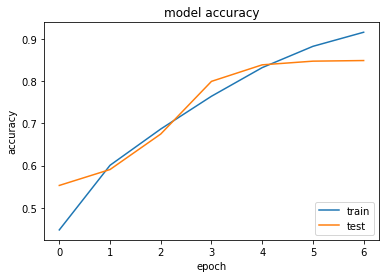

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history[ 'accuracy' ])
plt.plot(history.history[ 'val_accuracy' ])
plt.title( 'model accuracy' )
plt.ylabel( 'accuracy' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'lower right' )
plt.savefig('mdeol_accuracy.png')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


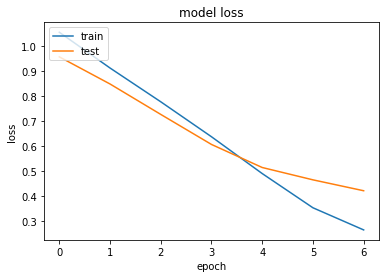

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history[ 'loss' ])
plt.plot(history.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.savefig('mdeol_loss.png')
plt.show()

In [ ]:
#save pickle
import pickle

with open("dummy_model_lstm.pkl","wb") as f:
  pickle.dump(model,f)

with open("dummy_tokenizer.pkl","wb") as f:
  pickle.dump(tokenizer,f)



In [ ]:
from tensorflow.keras.models import load_model,save_model

save_model(model, "best_model_lstm.h5")

model = load_model('model.h5')


In [ ]:
import pickle

pick_model_lstm = pickle.load(open("dump_model_lstm.pkl", 'rb'))     
pick_tokenizer = pickle.load(open("dump_tokenizer.pkl",'rb')) 


<H1> PREDICTION with MODEL (PICKLE) </H1>

In [ ]:
sentiment = ['Neutral','Negative','Positive']


sequence = pick_tokenizer.texts_to_sequences(['rasanya enak'])

test = pad_sequences(sequence, maxlen=128)

result = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

print(result)

1/1 [==============================] - 0s 97ms/step
Negative


In [ ]:
dummy_df = pd.read_csv("data.csv",encoding='latin-1')
dummy_df = dummy_df[['Tweet']].copy()

In [ ]:
import numpy as np
data_result = []

for i in range(len(dummy_df)):  
    data = [dummy_df['Tweet'][i]]

    sequence = pick_tokenizer.texts_to_sequences(data)
    print(sequence)
    test = pad_sequences(sequence, maxlen=128)
    result = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
    data_result.append(result)
    print(result)
    # count_vect_data = pick_cv.transform(data)
    # tfidf_data = pick_tf.transform(count_vect_data).toarray()
    # result = pick_model.predict(tfidf_data)
   

    # if result == 1:
    #    data_result.append("Positive")
    # elif result == 0:
    #    data_result.append("Neutral")
    # else:
    #    data_result.append("Negative")


dummy_df ['Label'] = data_result


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 49ms/step
Neutral
[[338, 181, 687, 281, 4, 817, 216, 281, 787, 99, 817, 1740, 144, 281, 591]]
1/1 [==============================] - 0s 51ms/step
Positive
[[422, 4792, 5480, 5480, 2523, 3908, 281, 6, 2406, 92, 92, 1338, 281]]
1/1 [==============================] - 0s 53ms/step
Neutral
[[4, 1137, 4, 5349, 134, 5128, 954]]
1/1 [==============================] - 0s 54ms/step
Neutral
[[93, 1810, 890, 419, 448, 435, 2966]]
1/1 [==============================] - 0s 50ms/step
Positive
[[645, 2703, 6601, 833, 2203, 1712, 833, 123, 3129, 2185, 6, 696, 383, 3121]]
1/1 [==============================] - 0s 54ms/step
Neutral
[[1817, 2406, 65, 1268, 1480, 1353, 1353]]
1/1 [==============================] - 0s 64ms/step
Positive
[[39, 73, 847, 60, 60, 376, 181]]
1/1 [==============================] - 0s 65ms/step
Neutral
[[1338, 1422, 3515, 7077, 1338, 1492, 5480]]
1/1 [==============================] - 0s 5

<H1> PLOT </H1>

In [ ]:
import pickle
#import model ann 
pick_model = pickle.load(open("/content/best_tfidf_model_mlp.pkl", 'rb'))     
#import model lstm


<h1> PLOT ANN </h1>

In [ ]:
y_predict = mlp.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))
print('nilai akurasinya adalah ',accuracy_score(y_test, y_predict))

NameError: ignored

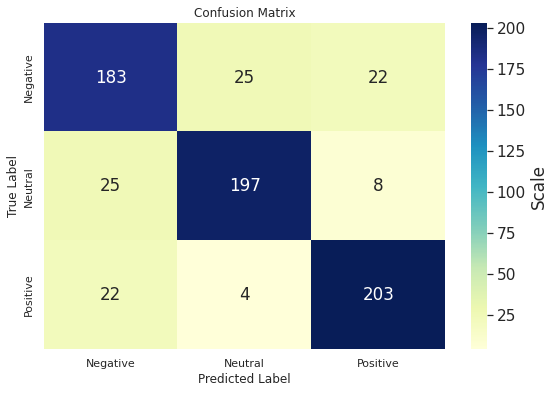

In [ ]:
import seaborn
import matplotlib.pyplot as plt
 
 
def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'},fmt='.0f')
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

labels = ['Negative','Neutral','Positive']

data = confusion_matrix(y_test,y_predict)

# create confusion matrix
plot_confusion_matrix(data, labels, "confusion_matrix.png")


In [ ]:
mlp.validation_scores_

[0.6847826086956522,
 0.7282608695652174,
 0.7971014492753623,
 0.8405797101449275,
 0.8188405797101449,
 0.8333333333333334,
 0.8152173913043478,
 0.8333333333333334,
 0.822463768115942,
 0.822463768115942,
 0.8115942028985508,
 0.8079710144927537,
 0.8079710144927537,
 0.8079710144927537,
 0.8043478260869565]

In [ ]:
mlp.loss_curve_

[1.0849718727524569,
 0.9376169265255684,
 0.6183200107007375,
 0.25009697720024515,
 0.08149735182361588,
 0.028703352947191767,
 0.013576594717169698,
 0.007345942013502472,
 0.00552301305647508,
 0.003997024331551643,
 0.002962237560547149,
 0.002685593174427865,
 0.002346175592754533,
 0.002557917906615361,
 0.0028699689426184135]

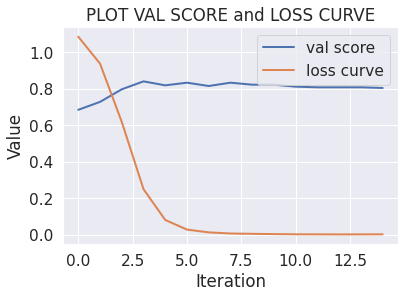

In [ ]:
import matplotlib.pyplot as plt

val_score  = mlp.validation_scores_
loss_curve = mlp.loss_curve_

plt.title('PLOT VAL SCORE and LOSS CURVE')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.plot(val_score,linewidth=2, label = 'val score')
plt.plot(loss_curve,linewidth=2, label = 'loss curve')
plt.legend()
plt.savefig('plotvalandloss.png')
plt.show()